# Random Forests and Tree Boosting



## 1 - Regression 

In this part, we apply Random Forests and Tree Boosting on the real estate dataset that we have seen before. 

**1) Load the data, split the data into a train set (80%) and a test set (20%).**

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

house = fetch_california_housing()
X, y = house.data, house.target
feature_names = house.feature_names

feature_mapping = {
    "MedInc": "Median income in block",
    "HousAge": "Median house age in block",
    "AveRooms": "Average number of rooms",
    "AveBedrms": "Average number of bedrooms",
    "Population": "Block population",
    "AveOccup": "Average house occupancy",
    "Latitude": "House block latitude",
    "Longitude": "House block longitude",
}

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

**2) Train a random forests with default parameters on these data and evaluate its performance on the training set and test set. Comment.** 

In [2]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create a random forest regressor
rf = RandomForestRegressor(random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the training set
y_pred_train = rf.predict(X_train)

# Make predictions on the test set
y_pred_test = rf.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("The Mean Squared Eror on the train is:", mse_train)
print("The Mean Squared Error on the test is:", mse_test)

print("A prediction with the mean of the output on the train set would result in an MSE of", np.var(y_train))
print("A prediction with the mean of the output on the test set would result in an MSE of", np.var(y_test))

# The errors on both train and test sets are lower than that of a naive prediction (by the mean). 
# The RF is doing a better job than the mean!
# The error on the train set is lower than that of the test set, by a factor almost three. 
# This is probably due to the overfitting phenomenon. 
# A better tuning of the hyperparameters could help to reduce this phenomenon
# The error of the RF on the test set is smaller than that of a decision tree (see previous session). 
# The RF is a more complex model, and can thus capture more complex interactions in the inputs, 
# resulting in better predictive performances. 


The Mean Squared Eror on the train is: 0.036220359800140565
The Mean Squared Error on the test is: 0.2728849823807957
A prediction with the mean of the output on the train set would result in an MSE of 1.3346482836699805
A prediction with the mean of the output on the test set would result in an MSE of 1.3218506541411585


**3) Based on the lecture, which parameter could have the biggest impact on the predictive performances of the forest? Plot the error of the forest as a function of this parameter.** 

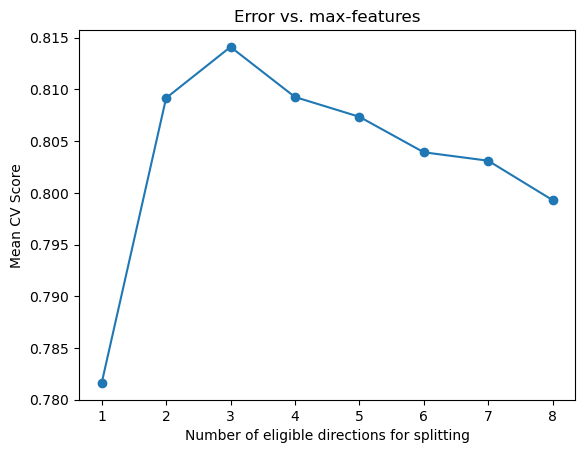

In [3]:
# The parameter that can have the greatest impact on the prediction is the max-features 
# (the number of randomly selected directions for splitting in each node).

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

#Setting the maximal depth to 15 according to the previous question
nb_directions = np.arange(1, X_train.shape[1]+1, 1)

# Store the mean cross-validation scores for each pruning parameter value
cv_scores = []

# Perform cross-validation for each pruning parameter value
for param in nb_directions:
    # Create a decision tree classifier with the specified pruning parameter
    clf = RandomForestRegressor(max_features = param, random_state=42)

    # Perform cross-validation and calculate the mean score, which is the coefficient of determination (R2) in regression
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    mean_score = np.mean(scores)
    cv_scores.append(mean_score)

# Plot the mean cross-validation scores as a function of pruning parameter values
plt.plot(nb_directions, cv_scores, marker='o')
plt.xlabel('Number of eligible directions for splitting')
plt.ylabel('Mean CV Score')
plt.title('Error vs. max-features')
plt.show()

**4) Train a forest with the best parameter found above. Comment.**

In [4]:
# The index corresponding to the largest cv_score can be found using argmax command
best_index = np.argmax(cv_scores)
# The corresponding penalization complexity parameter is 
best_max_feature = nb_directions[best_index]
print("The best value for the number of eligible directions for splitting is", best_max_feature)

# Create a random forest regressor
rf = RandomForestRegressor(max_features = best_max_feature, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the training set
y_pred_train = rf.predict(X_train)

# Make predictions on the test set
y_pred_test = rf.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("The Mean Squared Eror on the train is:", mse_train)
print("The Mean Squared Error on the test is:", mse_test)

#The prediction is a bit better than that of the default random forest that we first trained. 

The best value for the number of eligible directions for splitting is 3
The Mean Squared Eror on the train is: 0.0341556020595172
The Mean Squared Error on the test is: 0.24885328209861354


**5) Now, optimize jointly the parameters 'max-features' and 'max-depth' of the random forest. You can use the function 'GridSearchCV'.**

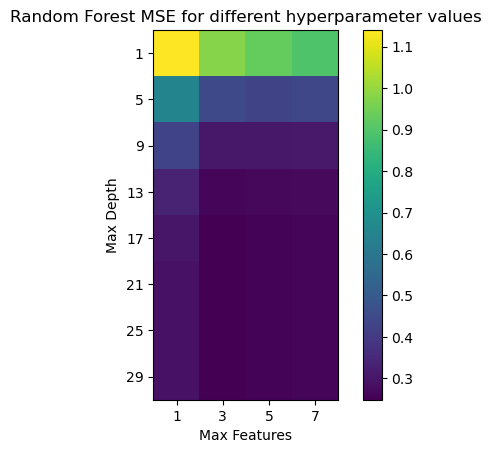

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Define the parameter grid for searching
param_grid = {
    'max_features': np.arange(1, X_train.shape[1]+1, 2),
    'max_depth': np.arange(1, 30, 4)
}

# Create the random forest regressor
rf = RandomForestRegressor(random_state=42)

# Define the scoring metric (mean squared error)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring=scoring)
grid_search.fit(X_train, y_train)

# Extract the results
scores = -grid_search.cv_results_['mean_test_score']
scores = scores.reshape(len(param_grid['max_depth']), len(param_grid['max_features']))

# Plot the results as a heatmap
fig, ax = plt.subplots()

#Create the heatmap
heatmap = ax.imshow(scores, cmap='viridis')

# Add colorbar
cbar = ax.figure.colorbar(heatmap, ax=ax)

ax.set_xticks(np.arange(len(param_grid['max_features'])))
ax.set_yticks(np.arange(len(param_grid['max_depth'])))
ax.set_xticklabels(param_grid['max_features'])
ax.set_yticklabels(param_grid['max_depth'])
ax.set_xlabel('Max Features')
ax.set_ylabel('Max Depth')
plt.title('Random Forest MSE for different hyperparameter values')
plt.show()

**6) Train the best resulting model and compute its error.** 

In [6]:
# The best parameters are given by 
print("The best parameters from the grid search cv are given by the command 'grid_search.best_params'. They are equal to", grid_search.best_params_)

# Create a random forest regressor
rf = RandomForestRegressor(max_features = grid_search.best_params_['max_features'], max_depth = grid_search.best_params_['max_depth'], random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the training set
y_pred_train = rf.predict(X_train)

# Make predictions on the test set
y_pred_test = rf.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("The Mean Squared Eror on the train is:", mse_train)
print("The Mean Squared Error on the test is:", mse_test)

# Sadly, the test error has not been improved via the joint tuning of these two parameters.
# It is of the same magnitude as the previous error, computed via the tuning of max-features only

The best parameters from the grid search cv are given by the command 'grid_search.best_params'. They are equal to {'max_depth': 25, 'max_features': 3}
The Mean Squared Eror on the train is: 0.03421975597589286
The Mean Squared Error on the test is: 0.24857032030314866


**7) Train a Gradient Boosting Decision Tree using 'GradientBoostingRegressor'. Tune the hyperparameters 'learning_rate' and 'max_depth' via cross-validation as above. Comment the results.**

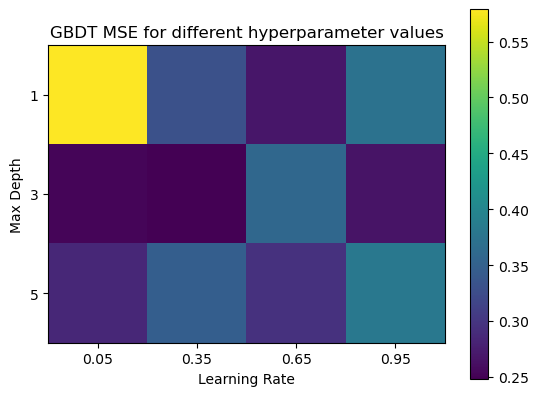

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Define the parameter grid for searching
param_grid = {
    'learning_rate': np.arange(0.05, 1, 0.3),
    'max_depth': np.arange(1, 7, 2)
}

# Create the random forest regressor
gbdt = GradientBoostingRegressor(random_state=42)

# Define the scoring metric (mean squared error)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search cross-validation
grid_search = GridSearchCV(gbdt, param_grid, cv=5, scoring=scoring)
grid_search.fit(X_train, y_train)

# Extract the results
scores = -grid_search.cv_results_['mean_test_score']
scores = scores.reshape(len(param_grid['max_depth']), len(param_grid['learning_rate']))

# Plot the results as a heatmap
fig, ax = plt.subplots()

#Create the heatmap
heatmap = ax.imshow(scores, cmap='viridis')

# Add colorbar
cbar = ax.figure.colorbar(heatmap, ax=ax)

ax.set_xticks(np.arange(len(param_grid['learning_rate'])))
ax.set_yticks(np.arange(len(param_grid['max_depth'])))
ax.set_xticklabels(param_grid['learning_rate'])
ax.set_yticklabels(param_grid['max_depth'])
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Max Depth')
plt.title('GBDT MSE for different hyperparameter values')
plt.show()

In [9]:
# The best parameters are given by 
print("The best parameters from the grid search cv are given by the command 'grid_search.best_params'. They are equal to", grid_search.best_params_)

# Create a random forest regressor
gbdt = GradientBoostingRegressor(learning_rate = grid_search.best_params_['learning_rate'], max_depth = grid_search.best_params_['max_depth'], random_state=42)

# Train the model
gbdt.fit(X_train, y_train)

# Make predictions on the training set
y_pred_train = gbdt.predict(X_train)

# Make predictions on the test set
y_pred_test = gbdt.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("The Mean Squared Eror on the training set is:", mse_train)
print("The Mean Squared Error on the test set is:", mse_test)

# The test error of GBDT is roughly the same as that of RF. 
# It is difficult to see how the performance depends on the two hyperparameters considered. 
# We may expect that a small change in the data or in another parameter could change the best parameter values 
# and the resulting performances. We could try to conduct more analysis to understand this dependence. 

The best parameters from the grid search cv are given by the command 'grid_search.best_params'. They are equal to {'learning_rate': 0.35, 'max_depth': 5}
The Mean Squared Eror on the training set is: 0.10120612864949281
The Mean Squared Error on the test set is: 0.23056131595930787


## 2 - Classification on a Toy dataset

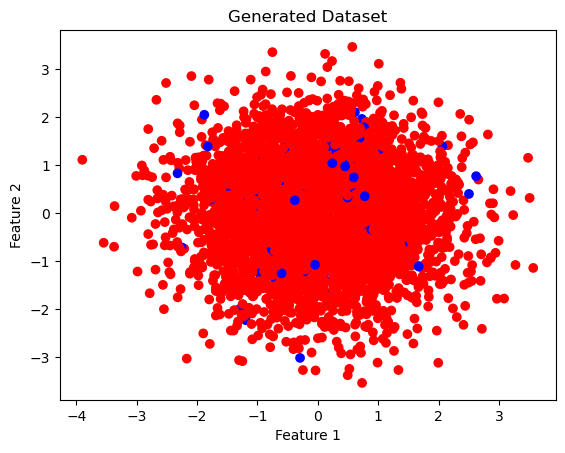

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# Create an imbalanced dataset
X, y = make_classification(n_samples=5000,weights=[0.02, 0.98],
                           random_state=0,n_clusters_per_class=1)

# Generate a classification dataset composed of two circles
#X, y = make_circles(n_samples=(200, 10), noise=0.1)

# Plot the generated dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Generated Dataset')
plt.show()

**8) Split the data set into a train and a test set. Train a random forest with max_depth = 2 on the training set. Plot its performance with a confusion matrix on the test set. Comment.**

The accuracy on the test set is  0.972


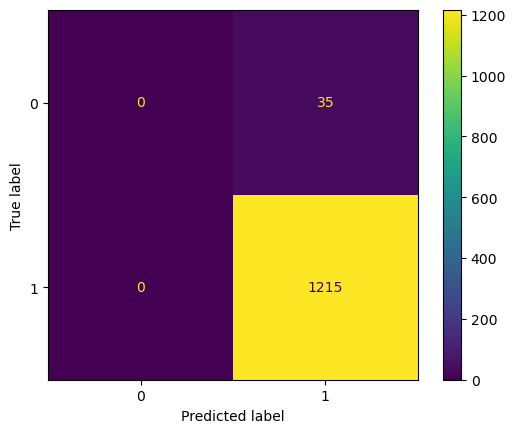

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True)


# Create a random forest regressor
rf = RandomForestClassifier(max_depth=2)

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the training set
y_pred_train = rf.predict(X_train)

# Make predictions on the test set
y_pred_test = rf.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
print("The accuracy on the test set is ", accuracy_test)

#The accuracy is very high, which seems to indicate that the model has good predictive performances. 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

# The confusion matrix shows that most observations are predicted as 1. 
# 1 here is the majority class, we can read in the confusion matrix that there are around 1200 true ones
# in the training data set. 
# There are only few tens of zeros in the training set
# Even if the accuracy is quite high, we see that the random forest fails ta capture the signal in the data. 
# All data are classified as one: the algorithm is not able to differentiate the two classes

In presence of an imbalanced data set, we need to pay attention to two different things: 
- when dividing the dataset into several parts (training/test), we want to keep the same proportion of observations in the resulting datasets. To do so, we use stratification. 
- we need to rebalance the training set so that it contains roughly the same proportions for the two classes. This can be done via the parameter 'class_weight'. It thus helps the training process by weighting up observations from the minority class. 
No matter what you do on the training set, you are not allowed to change the test set. It must reflect the true distribution of data. 

**9) Implement these modifications, train a forest and compare its performances.**

The accuracy on the test set is  0.9816


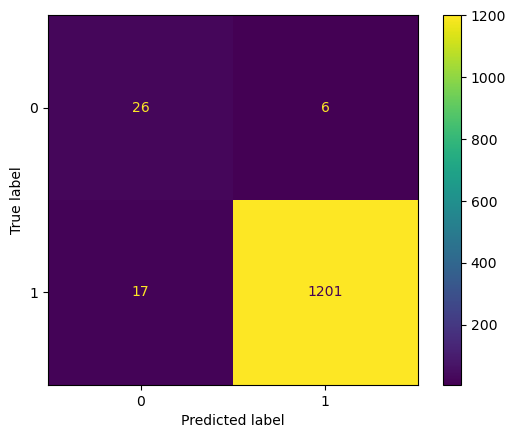

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)


# Create a random forest regressor
rf = RandomForestClassifier(max_depth = 2, class_weight = 'balanced')

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = rf.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
print("The accuracy on the test set is ", accuracy_test)

#The accuracy is very high, which seems to indicate that the model has good predictive performances. 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

# The method here does a better job at capturing the pattern in the data:
# more observations are predicted as zeros compared to the previous method.
# The accuracy is of the same magnitude but the two types of errors (predicting one instead of zero and the opposite)
# are of the same magnitude. 